In [1]:
#clarity ma rózne wielkości liter
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import patsy
import statsmodels.api as sm

In [2]:
dt = pd.read_csv("messy_data.csv")
dt = dt.rename(columns={'carat': 'carat', 
                        ' clarity': 'clarity', 
                        ' color': 'color', 
                        ' cut': 'cut', 
                        ' x dimension': 'x_dimension', 
                        ' y dimension': 'y_dimension', 
                        ' z dimension': 'z_dimension', 
                        ' depth': 'depth', 
                        ' table': 'table', 
                        ' price': 'price'
                        })
dt.replace(" ", np.NaN, inplace=True)
dt.drop_duplicates(list(dt.columns), inplace=True)
# dt.head(25)
# x, y, z i carat wysokie korelacje, bazują na sobie, table i depth zamieniam na średnią ponieważ jest mała różnica między wierszami, przy braku price usuwam, ponieważ są to tylko 4 wartości
dt[['x_dimension', 'y_dimension', 'z_dimension', 'table', 'price', 'depth']] = dt[['x_dimension', 'y_dimension', 'z_dimension', 'table', 'price', 'depth']].apply(pd.to_numeric)
dt['x_dimension'] = dt.apply(lambda row: row['y_dimension'] if np.isnan(row['x_dimension']) else row['x_dimension'], axis=1)
dt['y_dimension'] = dt.apply(lambda row: row['x_dimension'] if np.isnan(row['y_dimension']) else row['y_dimension'], axis=1)
z_to_x_and_y_correlation = dt['z_dimension'] / ((dt['x_dimension'] + dt['y_dimension']) / 2)
dt['z_dimension'] = dt.apply(lambda row: round((row['x_dimension'] + row['y_dimension']) / 2 * np.mean(z_to_x_and_y_correlation), 2) if np.isnan(row['z_dimension']) else row['z_dimension'], axis=1)
carat_to_x_correlation = dt['carat'] / dt['x_dimension']
dt['carat'] = dt.apply(lambda row: round(row['x_dimension'] * np.mean(carat_to_x_correlation), 2) if np.isnan(row['carat']) else row['carat'], axis=1)
dt['depth'].replace(np.NaN, round(np.mean(dt['depth']), 2), inplace=True)
dt['table'].replace(np.NaN, round(np.mean(dt['table']), 2), inplace=True)
dt['color'] = dt['color'].apply(lambda x: x.upper())
dt['clarity'] = dt['clarity'].apply(lambda x: x.upper())
dt['cut'] = dt['cut'].apply(lambda x: x.upper())
dt.dropna(subset=['price'], inplace=True)
print(dt.columns)


Index(['carat', 'clarity', 'color', 'cut', 'x_dimension', 'y_dimension',
       'z_dimension', 'depth', 'table', 'price'],
      dtype='object')


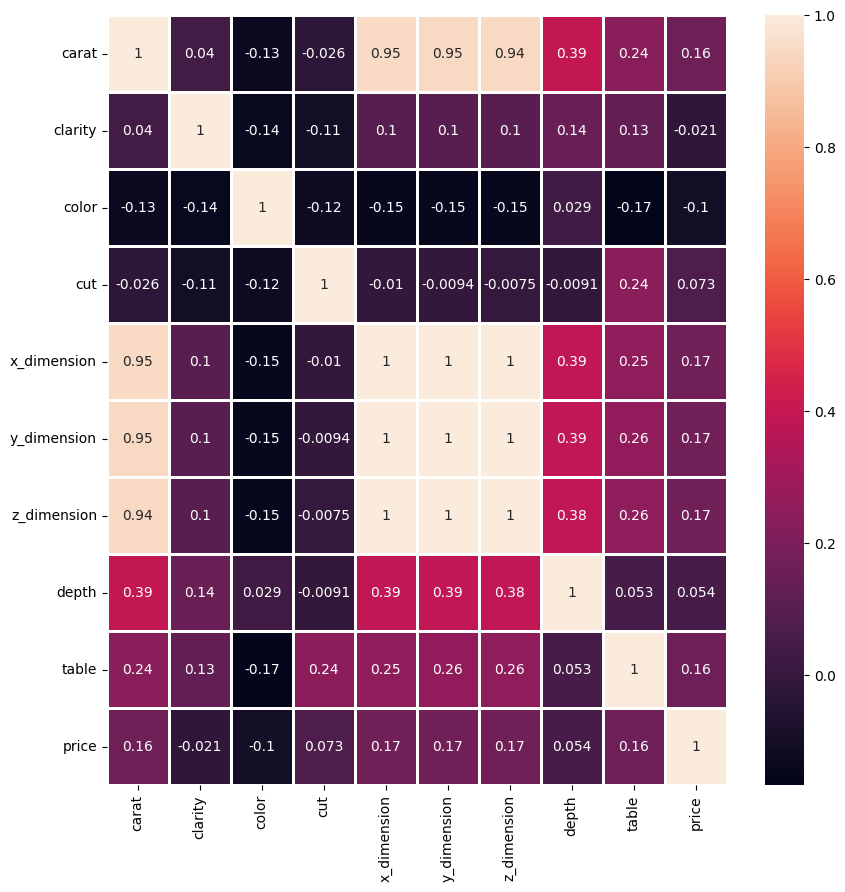

In [3]:
le_clarity = LabelEncoder()
le_color = LabelEncoder()
le_cut = LabelEncoder()
dt['clarity'] = le_clarity.fit_transform(dt['clarity'])
dt['color'] = le_color.fit_transform(dt['color'])
dt['cut'] = le_cut.fit_transform(dt['cut'])
plt.figure(figsize=(10, 10))
ax1 = sns.heatmap(dt.corr(), linewidths=2, annot=True)

Text(0.5, 1.0, 'depth')

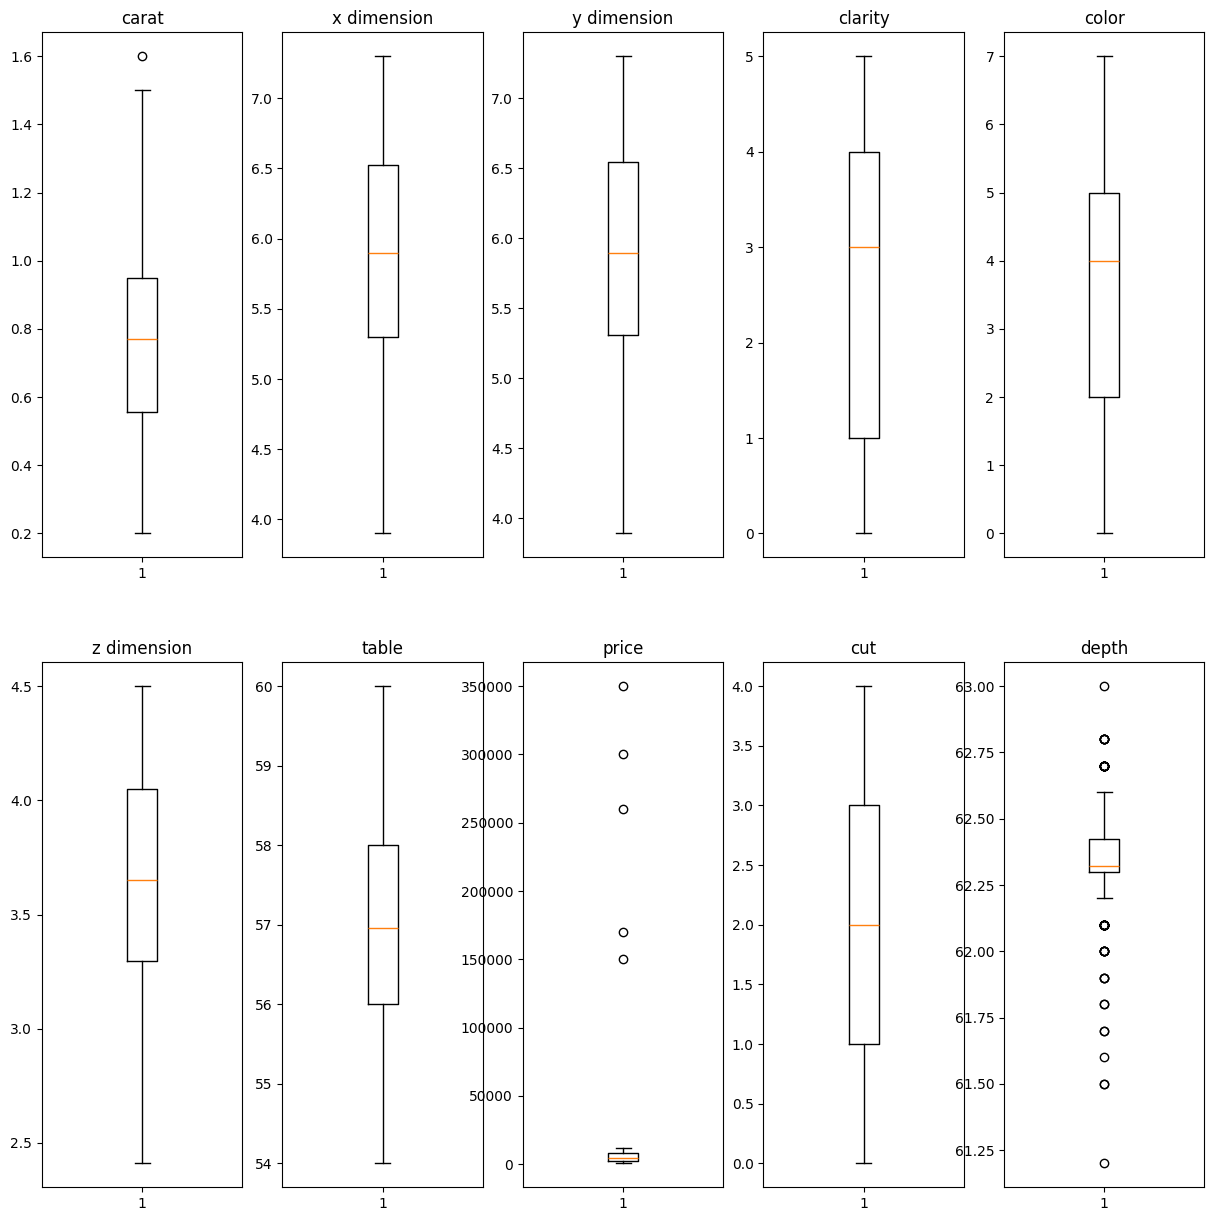

In [4]:
#Wizualizacja odchyleń danych liczbowych
fig, axs = plt.subplots(2, 5, figsize=(15, 15))
axs[0, 0].boxplot(dt['carat'])
axs[0, 0].set_title("carat")
axs[0, 1].boxplot(dt['x_dimension'])
axs[0, 1].set_title("x dimension")
axs[0, 2].boxplot(dt['y_dimension'])
axs[0, 2].set_title("y dimension")
axs[0, 3].boxplot(dt['clarity'])
axs[0, 3].set_title("clarity")
axs[0, 4].boxplot(dt['color'])
axs[0, 4].set_title("color")
axs[1, 0].boxplot(dt['z_dimension'])
axs[1, 0].set_title("z dimension")
axs[1, 1].boxplot(dt['table'])
axs[1, 1].set_title("table")
axs[1, 2].boxplot(dt['price'])
axs[1, 2].set_title("price")
axs[1, 3].boxplot(dt['cut'])
axs[1, 3].set_title("cut")
axs[1, 4].boxplot(dt['depth'])
axs[1, 4].set_title("depth")
# komentarz: wartości odstające są widoczne w atrybucie "carat" i "price"


In [5]:
#depth
Q1_depth = np.percentile(dt['depth'], 25, method='linear')
Q3_depth = np.percentile(dt['depth'], 75, method='linear')
IQR_depth = Q3_depth - Q1_depth
upper_treshold_depth = Q3_depth + 1.5 * IQR_depth
lower_treshold_depth = Q1_depth - 1.5 * IQR_depth

#carat
Q1_carat = np.percentile(dt['carat'], 25, method='linear')
Q3_carat = np.percentile(dt['carat'], 75, method='linear')
IQR_carat = Q3_carat - Q1_carat
upper_treshold_carat = Q3_carat + 1.5 * IQR_carat
lower_treshold_carat = Q1_carat - 1.5 * IQR_carat

#price
Q1_price = np.percentile(dt['price'], 25, method='linear')
Q3_price = np.percentile(dt['price'], 75, method='linear')
IQR_price = Q3_price - Q1_price
upper_treshold_price = Q3_price + 1.5 * IQR_price
lower_treshold_price = Q1_price - 1.5 * IQR_price

# Ucinanie wartości odstających dla kategorii depth, czrat i price do zakresu wąsów wykresu pudełkowego
dt['depth'] = dt['depth'].apply(lambda row: Q3_depth if row > Q3_depth else Q1_depth if row < Q1_depth else row)
dt['carat'] = dt['carat'].apply(lambda row: Q3_carat if row > Q3_carat else Q1_carat if row < Q1_carat else row)
dt['price'] = dt['price'].apply(lambda row: Q3_price if row > Q3_price else Q1_price if row < Q1_price else row)

# dt = dt.loc[(dt['depth'] < upper_treshold_depth) & (dt['depth'] > lower_treshold_depth)]
# dt = dt.loc[(dt['carat'] < upper_treshold_carat) & (dt['carat'] > lower_treshold_carat)]
# dt = dt.loc[(dt['price'] < upper_treshold_price) & (dt['price'] > lower_treshold_price)]
# dt['depth'] = np.where((dt['depth'] < upper_treshold) & (dt['depth'] > lower_treshold))


In [6]:
# Standaryzacja
X = dt.drop(['price'], axis=1)
y = dt['price']

scaler = StandardScaler()
scaler.fit_transform(X)


array([[-1.31401516, -1.00761619, -1.50712537, ..., -0.97602058,
        -0.88676273,  0.00876475],
       [-0.38951252,  1.36466937, -0.95703864, ..., -0.29158397,
        -0.88676273,  1.61161864],
       [-1.29779582,  0.17852659,  0.69322154, ..., -2.10961873,
        -0.88676273, -0.68912857],
       ...,
       [-1.31401516, -1.60068758,  1.24330827, ..., -0.80491143,
        -0.88676273,  0.07778717],
       [ 0.58364815,  0.17852659, -0.95703864, ...,  0.26452078,
        -0.50329776,  0.8447029 ],
       [ 0.51877077,  0.77159798,  0.14313481, ...,  0.67090503,
         1.50989329,  0.00876475]])

Text(0.5, 1.0, 'price(depth)')

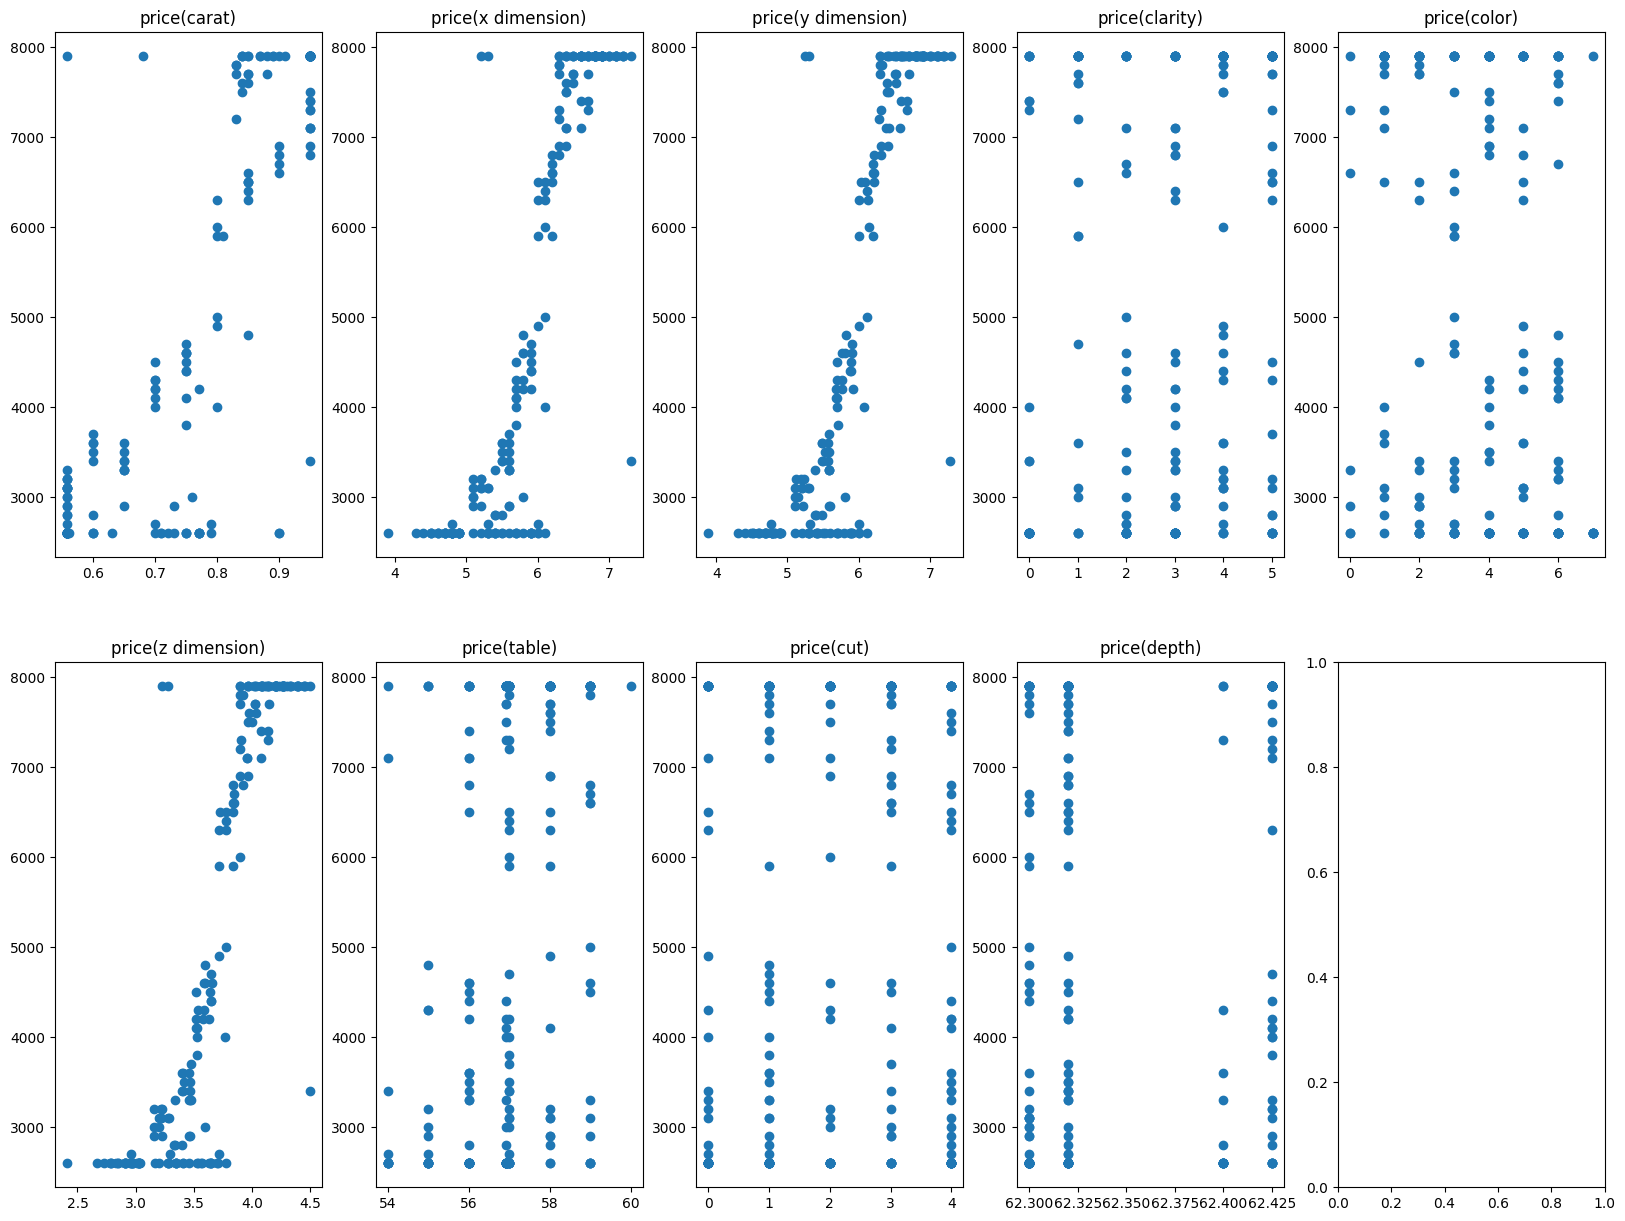

In [7]:
# Wizualizacja zależności ceny od poszczególnych atrybutów
fig, axs = plt.subplots(2, 5, figsize=(20, 15))
axs[0, 0].scatter(X['carat'], dt['price'])
axs[0, 0].set_title("price(carat)")
axs[0, 1].scatter(X['x_dimension'], dt['price'])
axs[0, 1].set_title("price(x dimension)")
axs[0, 2].scatter(X['y_dimension'], dt['price'])
axs[0, 2].set_title("price(y dimension)")
axs[0, 3].scatter(X['clarity'], dt['price'])
axs[0, 3].set_title("price(clarity)")
axs[0, 4].scatter(X['color'], dt['price'])
axs[0, 4].set_title("price(color)")
axs[1, 0].scatter(X['z_dimension'], dt['price'])
axs[1, 0].set_title("price(z dimension)")
axs[1, 1].scatter(X['table'], dt['price'])
axs[1, 1].set_title("price(table)")
axs[1, 2].scatter(X['cut'], dt['price'])
axs[1, 2].set_title("price(cut)")
axs[1, 3].scatter(X['depth'], dt['price'])
axs[1, 3].set_title("price(depth)")


Text(0.5, 1.0, 'price(depth)')

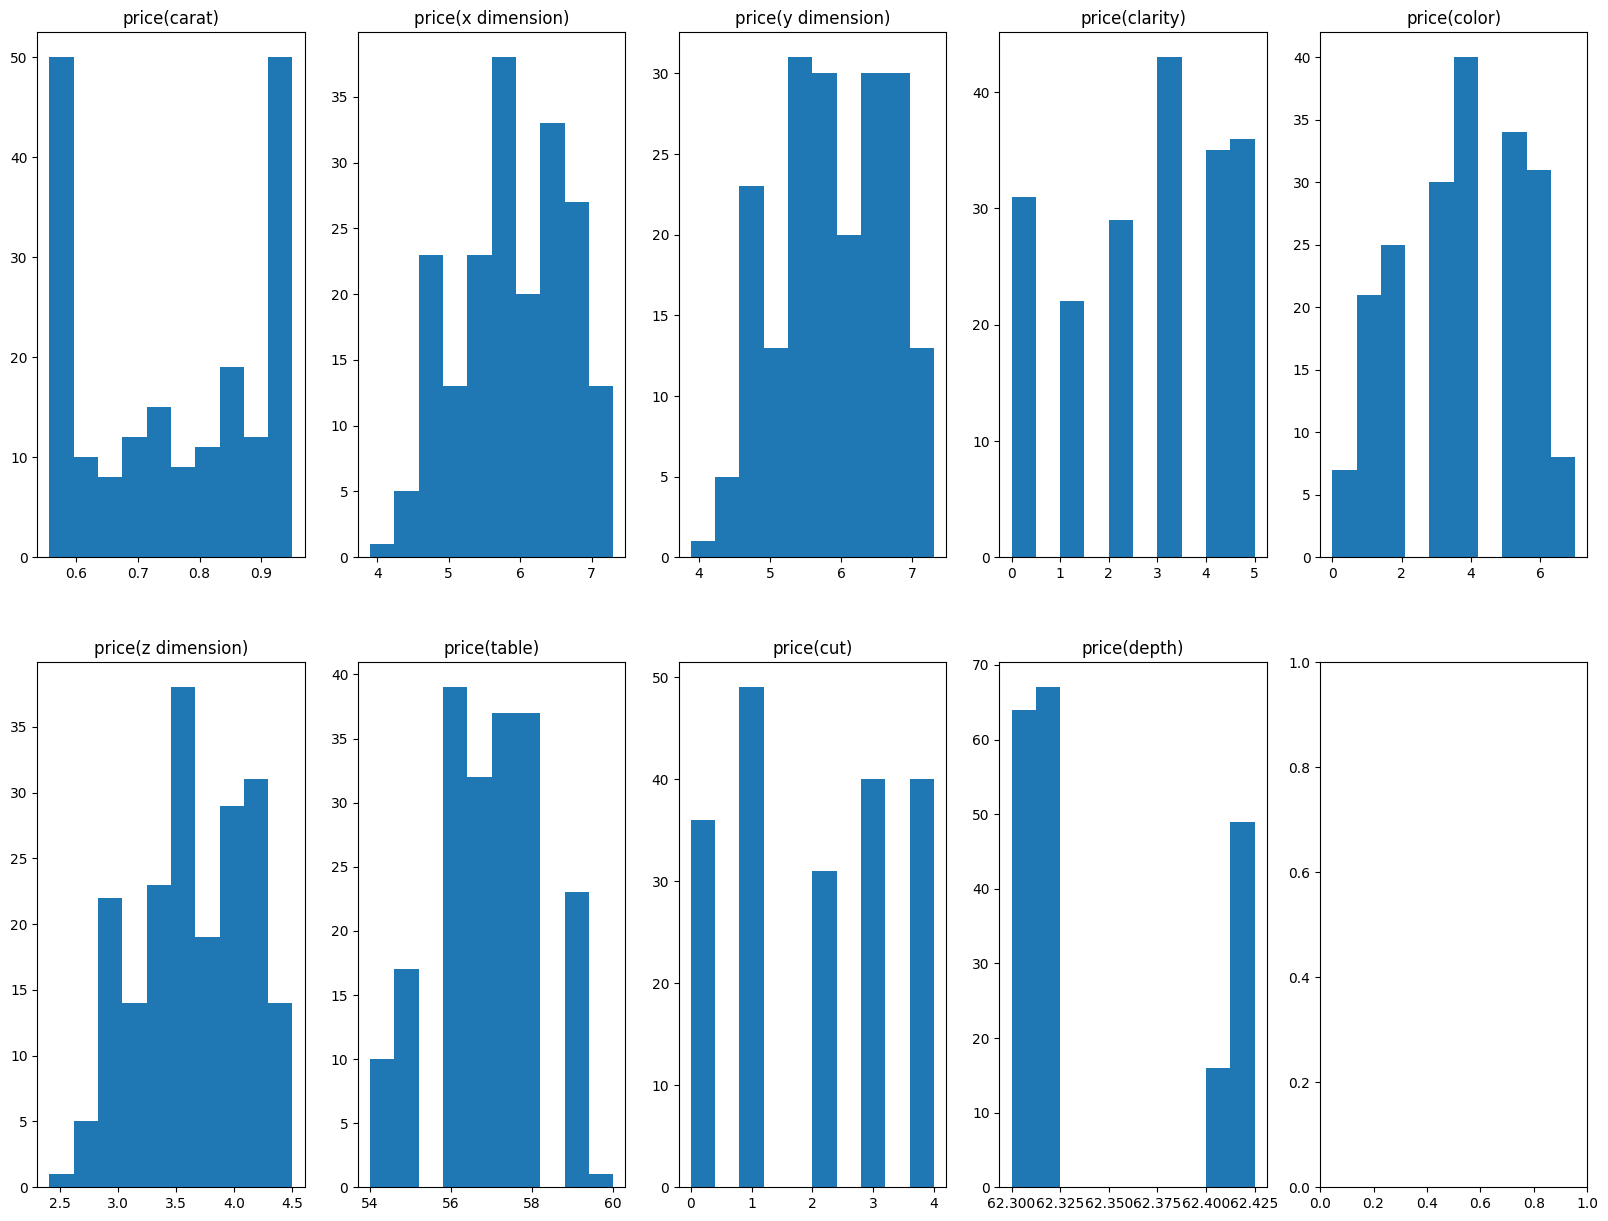

In [8]:
# Wizualizacja liczebności kategorii dla poszczególnych atrybutów
fig, axs = plt.subplots(2, 5, figsize=(20, 15))
axs[0, 0].hist(X['carat'])
axs[0, 0].set_title("price(carat)")
axs[0, 1].hist(X['x_dimension'])
axs[0, 1].set_title("price(x dimension)")
axs[0, 2].hist(X['y_dimension'])
axs[0, 2].set_title("price(y dimension)")
axs[0, 3].hist(X['clarity'])
axs[0, 3].set_title("price(clarity)")
axs[0, 4].hist(X['color'])
axs[0, 4].set_title("price(color)")
axs[1, 0].hist(X['z_dimension'])
axs[1, 0].set_title("price(z dimension)")
axs[1, 1].hist(X['table'])
axs[1, 1].set_title("price(table)")
axs[1, 2].hist(X['cut'])
axs[1, 2].set_title("price(cut)")
axs[1, 3].hist(X['depth'])
axs[1, 3].set_title("price(depth)")

Text(0.5, 1.0, 'price(depth)')

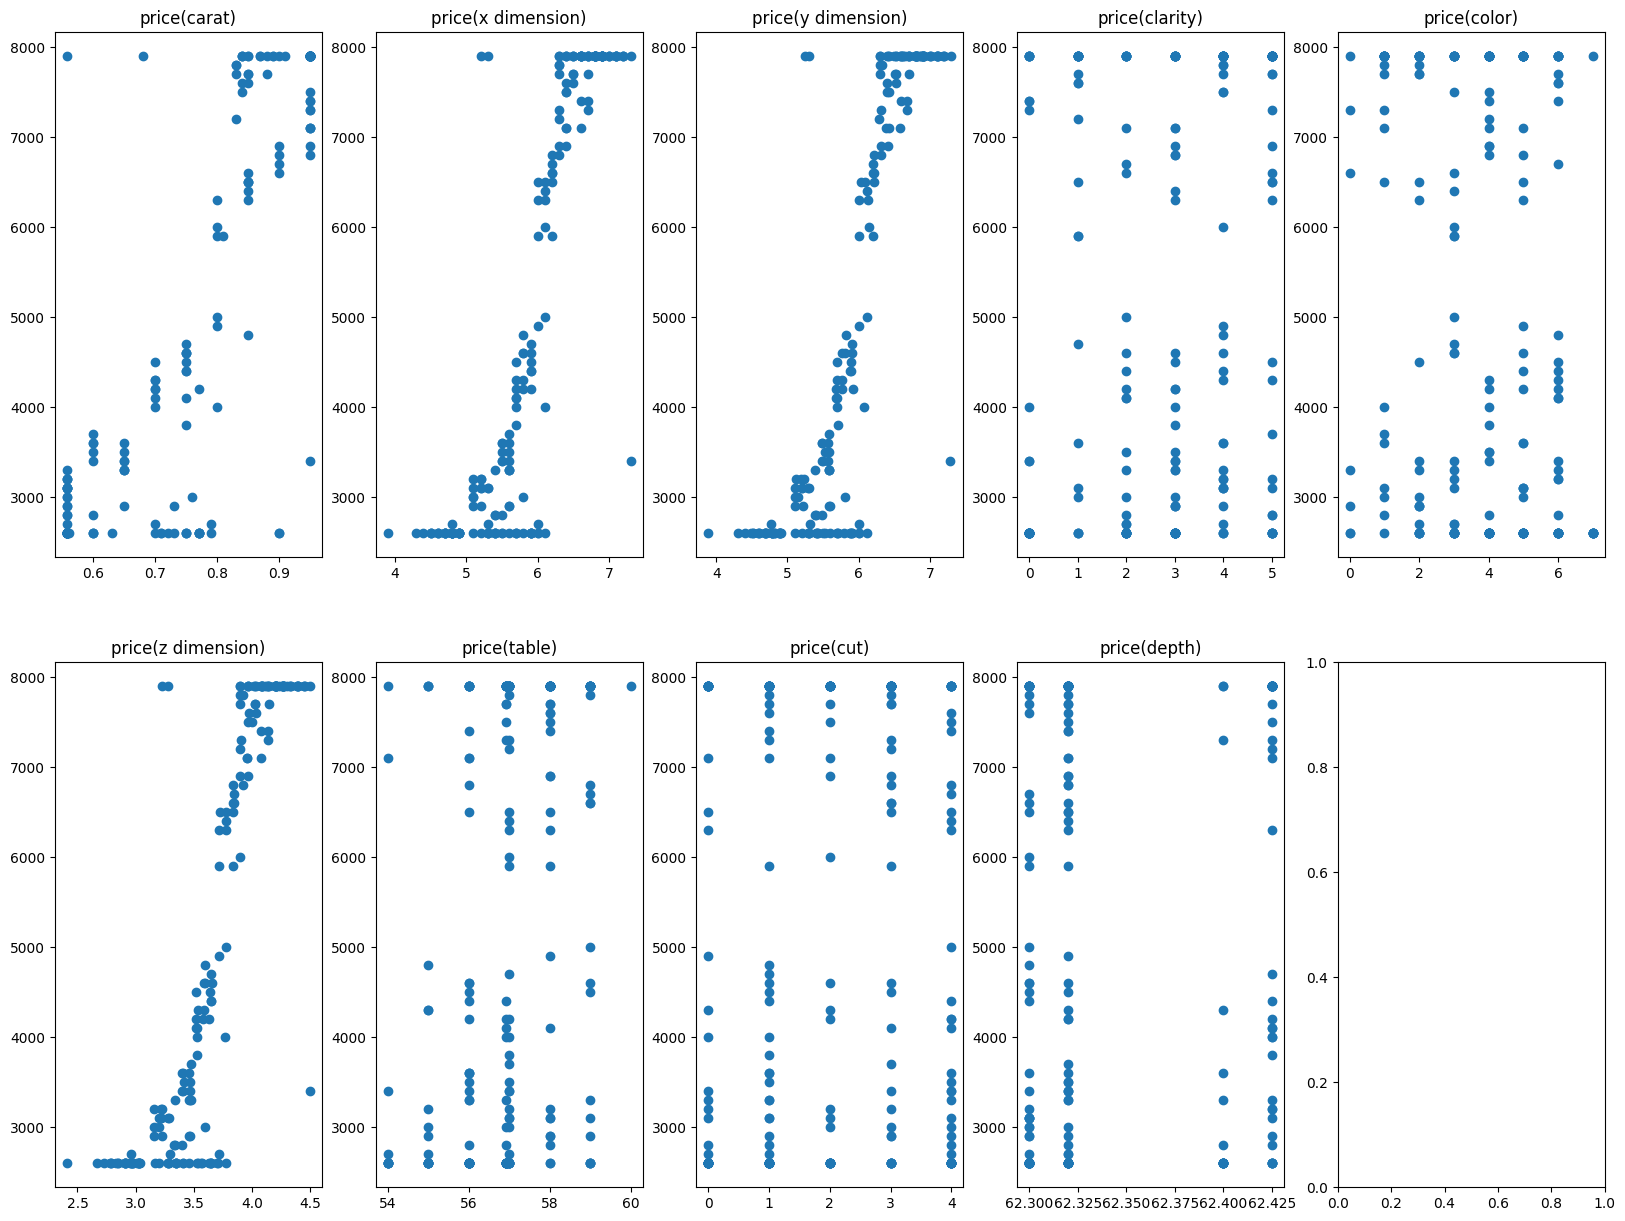

In [9]:
# Standaryzacja
X = dt.drop(['price'], axis=1)
y = dt['price']

scaler = StandardScaler()
scaler.fit_transform(X)

fig, axs = plt.subplots(2, 5, figsize=(20, 15))
axs[0, 0].scatter(X['carat'], dt['price'])
axs[0, 0].set_title("price(carat)")
axs[0, 1].scatter(X['x_dimension'], dt['price'])
axs[0, 1].set_title("price(x dimension)")
axs[0, 2].scatter(X['y_dimension'], dt['price'])
axs[0, 2].set_title("price(y dimension)")
axs[0, 3].scatter(X['clarity'], dt['price'])
axs[0, 3].set_title("price(clarity)")
axs[0, 4].scatter(X['color'], dt['price'])
axs[0, 4].set_title("price(color)")
axs[1, 0].scatter(X['z_dimension'], dt['price'])
axs[1, 0].set_title("price(z dimension)")
axs[1, 1].scatter(X['table'], dt['price'])
axs[1, 1].set_title("price(table)")
axs[1, 2].scatter(X['cut'], dt['price'])
axs[1, 2].set_title("price(cut)")
axs[1, 3].scatter(X['depth'], dt['price'])
axs[1, 3].set_title("price(depth)")


In [10]:

X_tv, X_test, y_tv, y_test = train_test_split(
         X, y, test_size=0.20, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
         X_tv, y_tv, test_size=0.30, random_state=42)
print(len(X_valid))

47


cross val score: [0.50488142 0.43806195]
[  7092.5902931     255.1680574     -33.94363859    108.82937686
 -18904.61484038  13798.11401983   9972.47513036  -1893.93523516
    129.14126742]
103209.69602960267


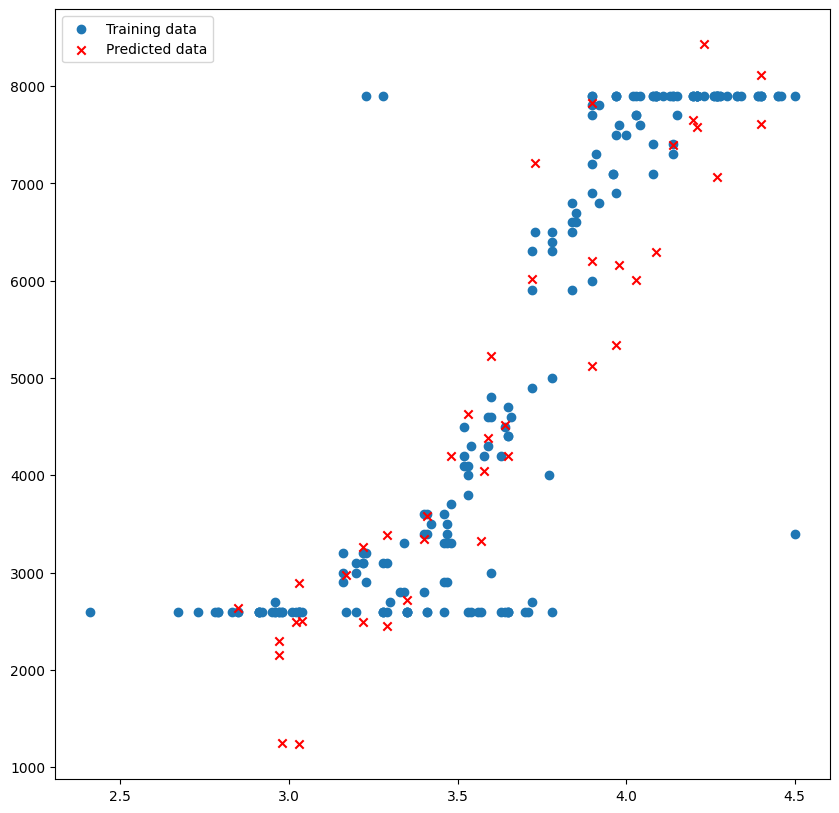

In [11]:
reg = LinearRegression()
print(f"cross val score: {cross_val_score(reg, X_valid, y_valid, cv=2)}") 
reg.fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
y_pred = reg.predict(X_test)

plt.figure(figsize=(10, 10))
plt.scatter(dt['z_dimension'], dt['price'])
plt.scatter(X_test['z_dimension'], y_pred, color="red", marker="x")
# plt.axline((0, reg.intercept_), slope=sum(reg.coef_))
plt.legend(["Training data", "Predicted data"])


In [12]:


lm1 = smf.ols(formula="price ~ x_dimension + y_dimension + z_dimension + carat", data=dt)
lm_fit1 = lm1.fit()
lm_fit1.summary()
# lm_fit1.params

# lm_fit1.rsquared


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     162.1
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           2.91e-60
Time:                        18:27:10   Log-Likelihood:                -1649.4
No. Observations:                 196   AIC:                             3309.
Df Residuals:                     191   BIC:                             3325.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -7808.4438    819.817     -9.525      0.000   -9425.502   -6191.385
x_dimension  -1.44e+04   5185.641     -2.777      0.006   -2.46e+04   -4172.961
y_dimension  1.139e+04   5946.623      1.915      0.057    -339.743    2.31e+04
z_dimension  7052.2538   6738.678      1.047      0.297   -6239.532    2.03e+04
carat        6414.7049   1464.374      4.381      0.000    3526.282    9303.128
==============================================================================
Omnibus:                       36.639   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.360
Skew:                          -0.577   Prob(JB):                     4.55e-37
Kurtosis:                       7.378   Cond. No.                         940.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
formula = "price ~"
for attr in dt.columns[:-1]:
    if formula[-1] == "~":
        formula += " " + attr
    else:
        formula += " + " + attr
    lm = smf.ols(formula=formula, data=dt)
    lm_fit = lm.fit()
    print(150 * "-")
    print("Użyte atrybuty do predykcji wartości ceny: " + formula)
    print(f"Procentowy wynik bazowany na miarze R^2: {round(lm_fit.rsquared * 100, 2)} %")
print(150 * "-")
   

------------------------------------------------------------------------------------------------------------------------------------------------------
Użyte atrybuty do predykcji wartości ceny: price ~ carat
Procentowy wynik bazowany na miarze R^2: 73.92 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Użyte atrybuty do predykcji wartości ceny: price ~ carat + clarity
Procentowy wynik bazowany na miarze R^2: 76.27 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Użyte atrybuty do predykcji wartości ceny: price ~ carat + clarity + color
Procentowy wynik bazowany na miarze R^2: 76.28 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Użyte atrybuty do predykcji wartości ceny: price ~

Text(0, 0.5, 'Residual')

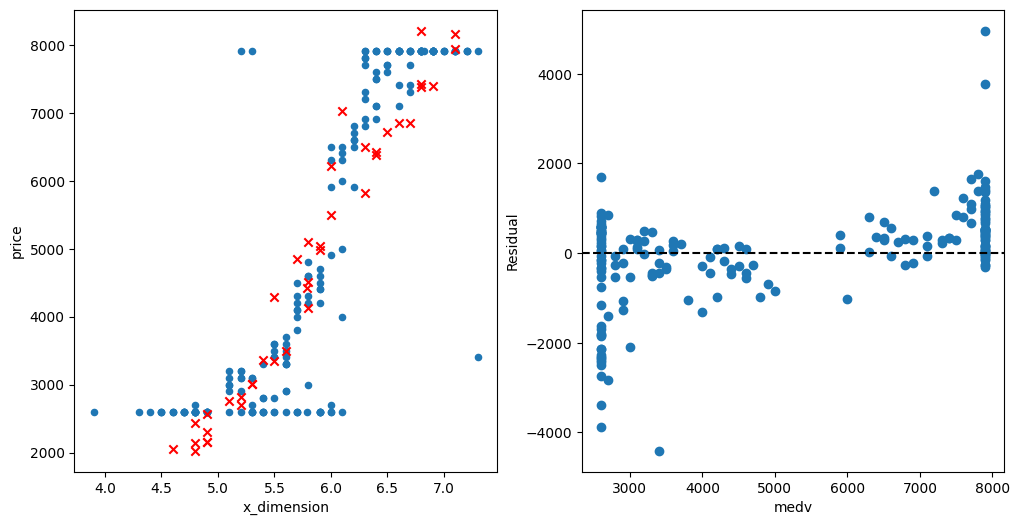

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dt.plot(kind='scatter', y='price', x='x_dimension', ax=ax1)
(b0, b1, b2, b3, b4) = lm_fit1.params
x_plot = np.linspace(dt.x_dimension.min(), dt.x_dimension.max(), 100)
y_plot = b0 + b1 * x_plot + b2 * x_plot + b3 * x_plot + b4 * x_plot 
plot = b0 + (b1 + b2 + b3 + b4) * x_plot 
# ax1.axline(xy1=(0,b0), slope=b1, color='k')
# ax1.plot(x_plot, y_plot, color='red')
ax1.scatter(X_test['x_dimension'], lm_fit1.predict(X_test), color='red', marker='x')
ax2.scatter(dt.price, lm_fit1.resid)
ax2.axhline(0, linestyle='--', color='k')
ax2.set_xlabel('medv')
ax2.set_ylabel('Residual')
